# Heart Segmentation

In [1]:
import os
import math
import numpy as np
import pandas as pd
import io
from PIL import Image
import scipy.io as sio
from sklearn.linear_model import LogisticRegression
from sklearn import svm

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential
from keras.layers import Dense
import tensorflow as tf
from skimage import color

# change the im_path variable in load_test function, which would be the path to image folders

In [2]:
# utils
def gray2rgb(image):
    width, height = image.shape
    out = np.empty((width, height, 3), dtype=np.uint8)
    out[:, :, 0] = image
    out[:, :, 1] = image
    out[:, :, 2] = image
    return out


def plot_result(img:np.ndarray, mask:np.ndarray, fig_path:str, name_panel = '', name_single = '') -> None:
    ''' to plot four panel images
    Params:
        img: image to be plotted
        mask: mask to be plotted 
        fig_path: save path
        name_panel: name of the four panel plot, set to '' if don't want to save
        name_single: name of the single red mask image to be saved, set to '' if don't want to save
    '''
#     img=mpimg.imread(im_path)

    fig = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

    ax1 = plt.subplot(2, 2, 1)
    imgplot = plt.imshow(img, cmap="gray")

    ax2 = plt.subplot(2, 2, 2)
    imgplot = plt.imshow(mask, cmap="gray")

    ax3 = plt.subplot(2, 2, 3)
    img = np.multiply(img,mask)
    imgplot = plt.imshow(gray2rgb(img * mask), cmap="gray")

    ax4 = plt.subplot(2, 2, 4)
    rgb = gray2rgb(img)

    for i in range(0, 100):
        for j in range(0, 100):
            if(rgb[i][j][0] == 0):
                rgb[i][j][0] = 255
    imgplot = plt.imshow(rgb)

    # save single red mask image
    if name_single != '':
        Image.fromarray(rgb.astype(np.uint8)).save(os.path.join(fig_path, name_single))
    
    ax1.title.set_text('Original Image')
    ax2.title.set_text('Mask Image')
    ax3.title.set_text('Masked Original Heart Image')
    ax4.title.set_text('Colored Masked Heart Image')
    
    # save the whole panel
    if name_panel != '':
        plt.savefig(os.path.join(fig_path, name_panel))
    plt.show()
    plt.clf()
  

def save_result(img:np.ndarray, mask:np.ndarray, fig_path:str, name:str) -> None:
    """ Save four panels separately instead of plot them together.
    Params: 
        img: img to be masked
        name: name to be saved
    """
#     img=mpimg.imread(im_path)
    tmp = np.dstack((img, img, img))
    Image.fromarray(tmp.astype(np.uint8)).save(os.path.join(fig_path, name+'origin.jpg'))
    
    tmp = np.dstack((mask, mask, mask)) * 255
    Image.fromarray(tmp.astype(np.uint8)).save(os.path.join(fig_path, name+'mask.jpg'))

    tmp = np.dstack((img, img, img)) * np.dstack((mask, mask, mask))
    Image.fromarray(tmp.astype(np.uint8)).save(os.path.join(fig_path, name+'maskorigin.jpg'))

    for i in range(0, 100):
        for j in range(0, 100):
            if(tmp[i][j][0] == 0):
                tmp[i][j][0] = 255
    Image.fromarray(tmp.astype(np.uint8)).save(os.path.join(fig_path, name+'red.jpg'))
    
    
def load_train(frame:int, csv_name:str, offset=0) -> (np.ndarray,np.ndarray,np.ndarray,np.ndarray): 
    '''To load training data from the csv. The csv is the manually selected data
    Note that the csv file assumed to be fixed and the data splited according to a constant.
    Params:
        frame: specify how many frames with be used for training, always start at the first frame.
        csv_name : name of the csv file
        offset: the start frame
    Returns:
        train_X, train_Y, val_X, val_Y
    '''
    data = pd.read_csv(csv_name)
    data = np.array(data)
    heart = []
    nonheart = []
    for i in range(data.shape[0]):
        if data[i][-1] == 0:
            heart.append(data[i])
        else:
            nonheart.append(data[i])
    heart = np.array(heart)
    nonheart = np.array(nonheart)
    print(heart.shape, nonheart.shape)
    train = np.concatenate((heart[:5066,:], nonheart[:800, :]))
    val = np.concatenate((heart[5066:,:], nonheart[800:, :]))
    
    return train[:, offset:frame+offset], train[:, -1], val[:, offset:frame+offset], val[:, -1]
    

def load_test(frame:int, folder_name:str, offset=0) -> (np.ndarray,np.ndarray):
    '''To load data from the 1024 frames
    
    Params:
        frame: specify how many frames with be used to form the data.
        folder_name : path to the images with specific format.
    Returns:
        tmp: the data
        bgimg: np array of the first frame, which would be the original data later used for plotting.
    '''
    frame = frame
    im_path = '/Users/kevin/Desktop/Heart_Segmentation/data'
    im_name = os.path.join(im_path, folder_name)

    if offset == 0:
        offset += 1
    tmp = np.zeros([10000,1])
    for i in range(offset, frame+offset):
        n = im_name + str(i) + '.jpg'
        tt = np.array(Image.open(n)).reshape(10000,1)
        tmp = np.concatenate((tmp,tt),axis=1)

    tmp = tmp[:,1:]
#     tmp = tmp.reshape(100,100,frame)
    
    im_name = os.path.join(im_path, folder_name + '1.jpg')
    bgimg =mpimg.imread(im_name)
    return tmp, bgimg 

def load_train_test(frame:int, csv_name:str, folder_name:str, offset=0):
    '''To combine load_train and load_test.
    Params:
        frame: specify how many frames
        csv_name: to be used in load_train
        folder_name: to be used ln load_test
        offset: start of frame
    '''
    train_X, train_Y, val_X, val_Y = load_train(frame, csv_name, offset)
    test, bgimg = load_test(frame, folder_name, offset)
    return train_X, train_Y, val_X, val_Y, test, bgimg


def svm_predict(train_X, train_Y, val_X, val_Y, test, bgimg, n1, n2):
    ''' Train, predict and plot with SVM.
    Params:
        train_X, train_Y, val_X, val_Y from load_test
        test: test data
        bgimg: a single image to be masked and plotted on 
        n1: name of the panel to be saved, need .jpg/.png extension
        n2: name of a single masked red image, need .jpg/.png extension
        set n1 or n2 to '' if don't want to save the image
    
    '''
    clf = svm.SVC(gamma = 'auto', kernel = 'linear', probability=True)
    clf.fit(train_X,train_Y)
    print("Support Vector Machine Validation Accuracy : " + str(clf.score(val_X, val_Y)))

    a = clf.predict(test)
    a = np.reshape(a, (100,100))
    print('Support Vector Machine predicts ' + str(np.count_nonzero(a)))
    plot_result(bgimg, a, '../outputs', n1, n2)

def logistic_predict(train_X, train_Y, val_X, val_Y, test, bgimg, n1, n2):
    ''' Train, predict and plot with Logistic Regression.
    '''

    logistic = LogisticRegression(solver= 'liblinear').fit(train_X, train_Y)
    print("Logistic Regression Validation Accuracy : " + str(logistic.score(val_X, val_Y)))
    print(train_X.shape)
    print(test.shape)
    a = logistic.predict(test)
    print('Logistic Regression predicts ' + str(np.count_nonzero(a)))
    a = np.reshape(a, (100,100))
    plot_result(bgimg, a, '../outputs', n1, n2)

## SVM

In [ ]:
# !caution: set im_path = '/Users/kevin/Desktop/Heart_Segmentation/data' in load_test for test path

def svm_wrapper(img_path, s):
    '''
    - "../data/labeled_1024frame.csv" is the path to the mannually selected training data 
    - img_path: in the format of 'images/R1/i1/r1-1-' to read the raw images 
    - if either n1 or n2 in svm_predict is set to '', the coressponding figure will not be shown.
    - uncomment plt.show() in plot_result to see the function
    '''
    csv_name = "../data/labeled_1024frame.csv"
    train_X, train_Y, val_X, val_Y, test, bgimg =  load_train_test(32, csv_name, img_path)
    svm_predict(train_X, train_Y, val_X, val_Y, test, bgimg, n1='', n2=s+'SVM32.jpg')
    
    train_X, train_Y, val_X, val_Y, test, bgimg =  load_train_test(256, csv_name, img_path)
    svm_predict(train_X, train_Y, val_X, val_Y, test, bgimg, n1='', n2=s+'SVM256.jpg')
    
    train_X, train_Y, val_X, val_Y, test, bgimg =  load_train_test(512, csv_name, img_path)
    svm_predict(train_X, train_Y, val_X, val_Y, test, bgimg, n1='', n2=s+'SVM512.jpg')
    
    train_X, train_Y, val_X, val_Y, test, bgimg =  load_train_test(1024, csv_name, img_path)
    svm_predict(train_X, train_Y, val_X, val_Y, test, bgimg, n1='', n2=s+'SVM1024.jpg')
    
    
svm_wrapper('images/R1/i1/r1-1-', 'r1')
# svm_wrapper('images/R2/i1/r2-1-', 'r2')
# svm_wrapper('images/R3/i2/r3-2-', 'r3')
# svm_wrapper('images/R4/b1/r4b1-', 'r4')


## Logistic Regression

In [ ]:
def logistic_wrapper(img_path, s):
    '''See svm_wrapper'''
    csv_name = "../data/labeled_1024frame.csv"
    train_X, train_Y, val_X, val_Y, test, bgimg =  load_train_test(32, csv_name, img_path, 0)
    logistic_predict(train_X, train_Y, val_X, val_Y, test, bgimg, n1='', n2=s+'LR32.jpg')
    
    train_X, train_Y, val_X, val_Y, test, bgimg =  load_train_test(256, csv_name, img_path)
    logistic_predict(train_X, train_Y, val_X, val_Y, test, bgimg, n1='', n2=s+'LR256.jpg')
    
    train_X, train_Y, val_X, val_Y, test, bgimg =  load_train_test(512, csv_name, img_path)
    logistic_predict(train_X, train_Y, val_X, val_Y, test, bgimg, n1='', n2=s+'LR512.jpg')
    
    train_X, train_Y, val_X, val_Y, test, bgimg =  load_train_test(1024, csv_name, img_path)
    logistic_predict(train_X, train_Y, val_X, val_Y, test, bgimg, n1='', n2=s+'LR1024.jpg')

    
logistic_wrapper('images/R1/i1/r1-1-', 'r1')
# logistic_wrapper('images/R2/i1/r2-1-', 'r2')
# logistic_wrapper('images/R3/i2/r3-2-', 'r3')
# logistic_wrapper('images/R4/b1/r4b1-', 'r4')

## Combined Method

In [3]:
def k_means(data, loop=50, heart=True, ratio = 0.5):
    '''k-means function with distant discount factor.
    Params:
        data: dataset
        loop: num of iterations
        heart: whether to discount heart pixel. If true, we are discounting heart pixel and getting training points 
            for nonheart area. If false, we are getting training points for heart area.
        ratio: discound factor between 0-1 posed on distances.
    Return: 
        ss: a mask.
    '''
    _,_,dim = data.shape
    c1 = np.ones([dim,1])
    c2 = np.zeros([dim,1])

    ss = np.zeros([100,100])
    oldss = ss

    for i in range(loop):
    #     print(i)
        c1 = np.array([np.repeat(c1[i], 10000).reshape(100,100) for i in range(dim)])
        c1 = np.moveaxis(c1, 0, -1)

        c2 = np.array([np.repeat(c2[i], 10000).reshape(100,100) for i in range(dim)])
        c2 = np.moveaxis(c2, 0, -1)

        d1 = np.sum((data-c1)**2, 2)
        d2 = np.sum((data-c2)**2, 2)
        if heart:
            d1 *= ratio
        else:
            d2 *= ratio
        ss[d1<d2] = 1
        ss[d1>d2] = 2

        if len(ss[ss==1]) > 0:
            tmp = data
            xxx = np.ones([100,100])
            xxx[ss==2] = 0
            tmp = tmp * np.repeat(xxx[:, :, np.newaxis], dim, axis=2)
            c1 = np.sum(tmp, (1,0)) / len(ss[ss==1])
            c1 = c1.reshape(dim,1)

        else:
            c1 = np.random.rand(dim,1)


        if len(ss[ss==2]) > 0:
            tmp = data
            xxx = np.ones([100,100])
            xxx[ss==1] = 0
            tmp = tmp * np.repeat(xxx[:, :, np.newaxis], dim, axis=2)
            c2 = np.sum(tmp, (1,0)) / len(ss[ss==2])
            c2 = c2.reshape(dim,1)
        else:
            c2 = np.random.rand(dim,1)
    ss = np.where(ss == 2, 1, 0)
    return ss

def count_adja(mask, r:int, i, j):
    '''Help function for remove_noise function.
    '''
    count = -1
    v = mask[i][j]
    for m in range(i-r, i+r+1):
        for n in range(j-r, j+r+1):
            if mask[m][n] == v:
                count+=1
    return count 

def remove_noise(mask:np.ndarray, thresh = 1, exten = 1, rheart=True, rnonheart=True):
    '''To remove noises from the mask.
    '''
    s1 = mask.shape[0]
    s2 = mask.shape[1]

    for i in range(s1):
        for j in range(s2):
            if (not rheart) and mask[i][j] == 1:
                continue
            if (not rnonheart) and mask[i][j] == 0:
                continue
            if (i < exten) or (i >= s1-exten) or (j < exten) or (j >= s2-exten):
                continue 
            if count_adja(mask, exten, i, j) <= thresh:
                mask[i][j] = 1-mask[i][j]
    return mask

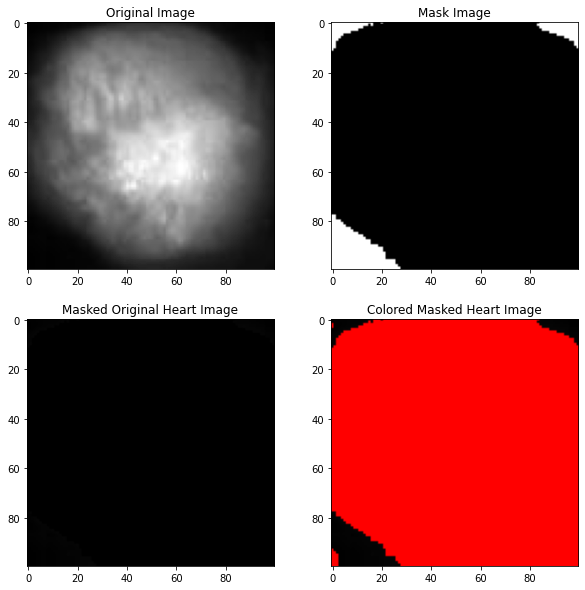

<Figure size 432x288 with 0 Axes>

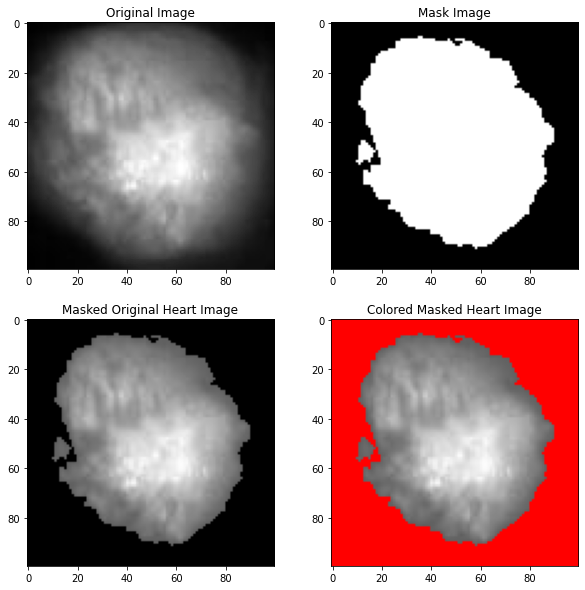

Accummulative Training Data: Heart: 4944, nonheart: 525


<Figure size 432x288 with 0 Axes>

In [15]:
def kmeans_train_data(img_path, X_heart, X_non_heart, Y_heart, Y_non_heart):
    """ Extract training data using k-means function.
    Run k-means with discount factor twice and get the heart and nonheart training pixels
    
    """
    test, bgimg = load_test(1024, img_path)

    nonheart_mask = k_means(test.reshape(100,100,1024), 100, True, 0.001)
    plot_result(bgimg, nonheart_mask, '../plots/figs4', "", '')

    heart_mask = k_means(test.reshape(100,100,1024), 100, False, 0.8)
    plot_result(bgimg, heart_mask, '../plots/figs4', "", '')

    heart_mask = heart_mask.reshape(10000,)
    nonheart_mask = nonheart_mask.reshape(10000,)

#     print(np.sum(heart_mask), (10000- np.sum(nonheart_mask)))

    for i in range(10000):
        if heart_mask[i] == 1:
            Y_heart.append(1)
            X_heart.append(test[i, :])
        elif nonheart_mask[i] == 1:
            Y_non_heart.append(0)
            X_non_heart.append(test[i, :])   
    
    print(f"Accummulative Training Data: Heart: {len(X_heart)}, nonheart: {len(X_non_heart)}")
#     return X_heart, X_non_heart, Y_heart, Y_non_heart



X_heart, X_non_heart, Y_heart, Y_non_heart = [], [], [], []


kmeans_train_data('images/R1/i1/r1-1-', X_heart, X_non_heart, Y_heart, Y_non_heart)
kmeans_train_data('images/R2/i1/r2-1-', X_heart, X_non_heart, Y_heart, Y_non_heart)                                                             
kmeans_train_data('images/R3/i1/r3-1-', X_heart, X_non_heart, Y_heart, Y_non_heart)   

X_heart, X_non_heart, Y_heart, Y_non_heart = np.array(X_heart), np.array(X_non_heart), np.array(Y_heart), np.array(Y_non_heart)

X = np.concatenate((X_heart[:5066, :], X_non_heart[:800, :]))
Y = np.concatenate((Y_heart[:5066], Y_non_heart[:800]))
print(X.shape)
print(Y.shape)




Support Vector Machine Validation Accuracy : 1.0
Support Vector Machine predicts 7143


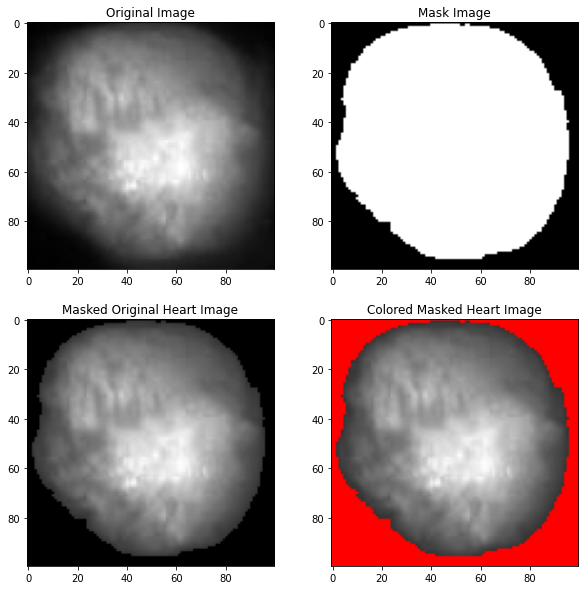

<Figure size 432x288 with 0 Axes>

In [14]:
def combined_svm_wrapper(img_path, s, X, Y):
    test, bgimg = load_test(32, img_path)
    svm_predict(X[:,:32], Y, X[:,:32], Y, test, bgimg, '', '')
#     test, bgimg = load_test(256, img_path)
#     svm_predict(X[:,:256], Y, X[:,:256], Y, test, bgimg, '', '')
#     test, bgimg = load_test(512, img_path)
#     svm_predict(X[:,:512], Y, X[:,:512], Y, test, bgimg, '', '')
#     test, bgimg = load_test(1024, img_path)
#     svm_predict(X[:,:1024], Y, X[:,:1024], Y, test, bgimg, '', '')

combined_svm_wrapper('images/R1/i1/r1-1-', 'r1', X, Y)
# combined_svm_wrapper('images/R2/i1/r2-1-', 'r2', X, Y)
# combined_svm_wrapper('images/R3/i2/r3-2-', 'r3', X, Y)
# combined_svm_wrapper('images/R4/b1/r4b1-', 'r4', X, Y)




## Other

In [3]:
####### combine masks back to video with 30 as step

test, bgimg = load_test(1024, 'images/R3/i1/r3-1-')
s = 'r3'
clf = svm.SVC(gamma = 'auto', kernel = 'linear', probability=True)
clf.fit(X[:,:30], Y)

step = 30
for k in range(1024-step):
    data = test[:, k:k+30]
    a = clf.predict(data)
    a = np.reshape(a, (100,100))
    bg = np.reshape(test[:, k], (100,100))
    
    img = np.multiply(bg,a)
    rgb = gray2rgb(img)

    for i in range(0, 100):
        for j in range(0, 100):
            if(rgb[i][j][0] == 0):
                rgb[i][j][0] = 255
    Image.fromarray(rgb.astype(np.uint8)).save(os.path.join('../outputs/'+s, str(k)+'.jpg'))

os.system(f'ffmpeg -r 30 -i ../outputs/'+ s + '/%d.jpg -c:v libx264 -vf fps=30 -pix_fmt yuv420p ../outputs/'+s+'.mp4')